In [ ]:
!pip install -q efficientnet shap scikit-learn opencv-python pandas matplotlib seaborn

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import shap
import efficientnet.tfkeras as efn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# STEP 2: Mount Drive and Load APTOS (final correct version)
from google.colab import drive
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/Colab_Notebooks/DR_Project/'
csv_file = base_path + 'train.csv'
img_folder = base_path + 'train_images/'

import os
import pandas as pd

aptos_df = pd.read_csv(csv_file)
aptos_df['id_code'] = aptos_df['id_code'].astype(str)
aptos_df['filepath'] = aptos_df['id_code'].apply(lambda x: os.path.join(img_folder, f"{x}.png"))

# Check
print("First image path:", aptos_df['filepath'].iloc[0])
print("Exists?", os.path.exists(aptos_df['filepath'].iloc[0]))
aptos_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
First image path: /content/drive/MyDrive/Colab_Notebooks/DR_Project/train_images/000c1434d8d7.png
Exists? True


,id_code,diagnosis,filepath
0,000c1434d8d7,2,/content/drive/MyDrive/Colab_Notebooks/DR_Proj...
1,001639a390f0,4,/content/drive/MyDrive/Colab_Notebooks/DR_Proj...
2,0024cdab0c1e,1,/content/drive/MyDrive/Colab_Notebooks/DR_Proj...
3,002c21358ce6,0,/content/drive/MyDrive/Colab_Notebooks/DR_Proj...
4,005b95c28852,0,/content/drive/MyDrive/Colab_Notebooks/DR_Proj...


In [ ]:
# STEP 3: TensorFlow-based image preprocessing (uses CPU, avoid GPU burnout)
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm

# Define image preprocessing function
def preprocess_with_tf(filepath):
    img_raw = tf.io.read_file(filepath)
    img_tensor = tf.image.decode_png(img_raw, channels=3)
    img_resized = tf.image.resize(img_tensor, [224, 224])
    img_normalized = img_resized / 255.0
    return img_normalized.numpy()

# Safe batch-wise image loader
def batch_preprocess_images_tf(filepaths, batch_size=500):
    all_images = []
    for i in range(0, len(filepaths), batch_size):
        batch_paths = filepaths[i:i+batch_size]
        batch_imgs = [preprocess_with_tf(fp) for fp in tqdm(batch_paths, desc=f"Processing {i}-{i+batch_size}") if os.path.exists(fp)]
        all_images.extend(batch_imgs)
    return np.array(all_images)

# Start processing images (takes ~7–10 mins on CPU, but only once)
X_images = batch_preprocess_images_tf(aptos_df['filepath'].tolist(), batch_size=500)
y_labels = aptos_df['diagnosis'].values

In [ ]:
  # STEP 3B: Simulate metadata
np.random.seed(42)
X_meta_df = pd.DataFrame({
    'age': np.random.normal(55, 10, len(aptos_df)),
    'diabetes_years': np.random.randint(1, 25, len(aptos_df)),
    'hba1c': np.random.normal(7.2, 1.0, len(aptos_df)),
    'systolic_bp': np.random.normal(135, 15, len(aptos_df)),
    'bmi': np.random.normal(27, 3, len(aptos_df)),
})
X_meta_array = ((X_meta_df - X_meta_df.mean()) / X_meta_df.std()).values

In [ ]:
# ✅ STEP: Reload preprocessed images, metadata, and labels from saved .npy files
base_path = '/content/drive/MyDrive/Colab_Notebooks/DR_Project/'

X_images = np.load(base_path + 'X_images.npy')
X_meta_array = np.load(base_path + 'X_meta.npy')
y_labels = np.load(base_path + 'y_labels.npy')

print("✅ Reloaded successfully:")
print("Images:", X_images.shape)
print("Metadata:", X_meta_array.shape)
print("Labels:", y_labels.shape)

✅ Reloaded successfully:
Images: (3662, 224, 224, 3)
Metadata: (3662, 5)
Labels: (3662,)


In [ ]:
# Reload with memory mapping (safe)
X_images = np.load('/content/drive/MyDrive/Colab_Notebooks/DR_Project/X_images.npy', mmap_mode='r')
X_meta_array = np.load('/content/drive/MyDrive/Colab_Notebooks/DR_Project/X_meta.npy')
y_labels = np.load('/content/drive/MyDrive/Colab_Notebooks/DR_Project/y_labels.npy')

print(X_images.shape, X_meta_array.shape, y_labels.shape)

# Helper: create tf.data.Dataset
def make_dataset(imgs, meta, labels, batch_size=16, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(((imgs, meta), labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=512)
    dataset = dataset.batch(batch_size).prefetch(1)  # ⚠️ limit prefetch to 1 batch
    return dataset

(3662, 224, 224, 3) (3662, 5) (3662,)


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define your multimodal architecture
def build_multimodal_model():
    # Image branch
    image_input = Input(shape=(224, 224, 3))
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=image_input)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.3)(x)

    # Metadata branch
    meta_input = Input(shape=(5,))
    m = Dense(64, activation='relu')(meta_input)
    m = Dropout(0.3)(m)
    m = Dense(32, activation='relu')(m)

    # Combine branches
    combined = Concatenate()([x, m])
    z = Dense(64, activation='relu')(combined)
    output = Dense(5, activation='softmax')(z)

    model = Model(inputs=[image_input, meta_input], outputs=output)
    model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
import json
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tensorflow.keras.utils import to_categorical

# Create Fold 1
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = list(kf.split(X_images, y_labels))[0]

# Prepare data
X_train_img, X_val_img = X_images[train_idx], X_images[val_idx]
X_train_meta, X_val_meta = X_meta_array[train_idx], X_meta_array[val_idx]
y_train, y_val = y_labels[train_idx], y_labels[val_idx]

train_ds = make_dataset(X_train_img, X_train_meta, y_train, batch_size=16)
val_ds = make_dataset(X_val_img, X_val_meta, y_val, batch_size=16, shuffle=False)

# Build and train model
model = build_multimodal_model()
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[es], verbose=1)

# Predict and evaluate
preds = model.predict(val_ds)
preds_labels = np.argmax(preds, axis=1)

acc = accuracy_score(y_val, preds_labels)
f1 = f1_score(y_val, preds_labels, average='weighted')
try:
    auc = roc_auc_score(to_categorical(y_val, 5), preds, multi_class='ovr')
except:
    auc = float("nan")

print(f"\n✅ Fold 1 Results — ACC: {acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

# ✅ Save model
model.save('/content/drive/MyDrive/Colab_Notebooks/DR_Project/fold1_model.h5')

# ✅ Save metrics
metrics = {
    'fold': 1,
    'accuracy': acc,
    'f1_score': f1,
    'auc': auc
}
with open('/content/drive/MyDrive/Colab_Notebooks/DR_Project/fold1_metrics.json', 'w') as f:
    json.dump(metrics, f)

# ✅ Save predictions
results_df = pd.DataFrame({
    'true_label': y_val,
    'predicted_label': preds_labels
})
results_df.to_csv('/content/drive/MyDrive/Colab_Notebooks/DR_Project/fold1_predictions.csv', index=False)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 140s 326ms/step - accuracy: 0.6247 - loss: 1.0412 - val_accuracy: 0.4857 - val_loss: 1.4728
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.7667 - loss: 0.6402 - val_accuracy: 0.2756 - val_loss: 1.5276
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.8104 - loss: 0.4997 - val_accuracy: 0.5266 - val_loss: 1.2908
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.8337 - loss: 0.4339 - val_accuracy: 0.6494 - val_loss: 1.0124
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.8702 - loss: 0.3521 - val_accuracy: 0.2838 - val_loss: 1.4371
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.9050 - loss: 0.2766 - val_accuracy: 0.2428 - val_loss: 1.8822
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.9082 - loss: 0.2348 - val_accuracy: 0.3711 - val_loss: 1.7389
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.9397 - loss: 0.1915 


✅ Fold 1 Results — ACC: 0.6494, F1: 0.5695, AUC: 0.7629


In [ ]:
import json
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tensorflow.keras.utils import to_categorical

# ✅ Fold 2: Get train and validation indices
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = list(kf.split(X_images, y_labels))[1]  # ← FOLD 2

# Prepare data
X_train_img, X_val_img = X_images[train_idx], X_images[val_idx]
X_train_meta, X_val_meta = X_meta_array[train_idx], X_meta_array[val_idx]
y_train, y_val = y_labels[train_idx], y_labels[val_idx]

train_ds = make_dataset(X_train_img, X_train_meta, y_train, batch_size=16)
val_ds = make_dataset(X_val_img, X_val_meta, y_val, batch_size=16, shuffle=False)

# Build and train model
model = build_multimodal_model()
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[es], verbose=1)

# Predict and evaluate
preds = model.predict(val_ds)
preds_labels = np.argmax(preds, axis=1)

acc = accuracy_score(y_val, preds_labels)
f1 = f1_score(y_val, preds_labels, average='weighted')
try:
    auc = roc_auc_score(to_categorical(y_val, 5), preds, multi_class='ovr')
except:
    auc = float("nan")

print(f"\n✅ Fold 2 Results — ACC: {acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

# ✅ Save model
model.save('/content/drive/MyDrive/Colab_Notebooks/DR_Project/fold2_model.h5')

# ✅ Save metrics
metrics = {
    'fold': 2,
    'accuracy': acc,
    'f1_score': f1,
    'auc': auc
}
with open('/content/drive/MyDrive/Colab_Notebooks/DR_Project/fold2_metrics.json', 'w') as f:
    json.dump(metrics, f)

# ✅ Save predictions
results_df = pd.DataFrame({
    'true_label': y_val,
    'predicted_label': preds_labels
})
results_df.to_csv('/content/drive/MyDrive/Colab_Notebooks/DR_Project/fold2_predictions.csv', index=False)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 141s 325ms/step - accuracy: 0.5711 - loss: 1.1230 - val_accuracy: 0.4816 - val_loss: 1.4848
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.7667 - loss: 0.6357 - val_accuracy: 0.4761 - val_loss: 1.3185
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.8167 - loss: 0.5094 - val_accuracy: 0.3670 - val_loss: 1.5126
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.8414 - loss: 0.4280 - val_accuracy: 0.4966 - val_loss: 1.2668
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.8749 - loss: 0.3323 - val_accuracy: 0.6971 - val_loss: 0.9037
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.9070 - loss: 0.2619 - val_accuracy: 0.3533 - val_loss: 1.4724
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.9279 - loss: 0.2057 - val_accuracy: 0.1487 - val_loss: 2.0528
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.9430 - loss: 0.1696 


✅ Fold 2 Results — ACC: 0.6971, F1: 0.6496, AUC: 0.8293


In [ ]:
# ✅ Clear memory from previous folds
import gc
import tensorflow as tf
tf.keras.backend.clear_session()
gc.collect()

0

In [ ]:
# Required imports for training and metrics
import json
import pandas as pd
import gc
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# ✅ Fold 3: Get train and validation indices
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = list(kf.split(X_images, y_labels))[2]  # ← FOLD 3

# Prepare data
X_train_img, X_val_img = X_images[train_idx], X_images[val_idx]
X_train_meta, X_val_meta = X_meta_array[train_idx], X_meta_array[val_idx]
y_train, y_val = y_labels[train_idx], y_labels[val_idx]

train_ds = make_dataset(X_train_img, X_train_meta, y_train, batch_size=16)
val_ds = make_dataset(X_val_img, X_val_meta, y_val, batch_size=16, shuffle=False)

# Build and train model
model = build_multimodal_model()
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[es], verbose=1)

# Predict and evaluate
preds = model.predict(val_ds)
preds_labels = np.argmax(preds, axis=1)

acc = accuracy_score(y_val, preds_labels)
f1 = f1_score(y_val, preds_labels, average='weighted')
try:
    auc = roc_auc_score(to_categorical(y_val, 5), preds, multi_class='ovr')
except:
    auc = float("nan")

print(f"\n✅ Fold 3 Results — ACC: {acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

# ✅ Save model
model.save('/content/drive/MyDrive/Colab_Notebooks/DR_Project/fold3_model.h5')

# ✅ Save metrics
metrics = {
    'fold': 3,
    'accuracy': acc,
    'f1_score': f1,
    'auc': auc
}
with open('/content/drive/MyDrive/Colab_Notebooks/DR_Project/fold3_metrics.json', 'w') as f:
    json.dump(metrics, f)

# ✅ Save predictions
results_df = pd.DataFrame({
    'true_label': y_val,
    'predicted_label': preds_labels
})
results_df.to_csv('/content/drive/MyDrive/Colab_Notebooks/DR_Project/fold3_predictions.csv', index=False)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 158s 396ms/step - accuracy: 0.5830 - loss: 1.1146 - val_accuracy: 0.4740 - val_loss: 1.4957
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.7682 - loss: 0.6261 - val_accuracy: 0.3675 - val_loss: 1.3532
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.8176 - loss: 0.4951 - val_accuracy: 0.1831 - val_loss: 2.0307
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.8439 - loss: 0.4274 - val_accuracy: 0.3142 - val_loss: 1.4569
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.8688 - loss: 0.3554 - val_accuracy: 0.2691 - val_loss: 1.7452
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.9106 - loss: 0.2721 - val_accuracy: 0.1216 - val_loss: 1.7489
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.9176 - loss: 0.2401 - val_accuracy: 0.5096 - val_loss: 1.3000
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.9386 - loss: 0.1906 


✅ Fold 3 Results — ACC: 0.5096, F1: 0.4619, AUC: 0.7563


In [ ]:
# ✅ Clear memory before Fold 4
import gc
import tensorflow as tf
tf.keras.backend.clear_session()
gc.collect()

# ✅ Fold 4 training block
from sklearn.model_selection import StratifiedKFold
import json
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tensorflow.keras.utils import to_categorical

# Fold 4: Get indices
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = list(kf.split(X_images, y_labels))[3]  # ← FOLD 4

# Prepare data
X_train_img, X_val_img = X_images[train_idx], X_images[val_idx]
X_train_meta, X_val_meta = X_meta_array[train_idx], X_meta_array[val_idx]
y_train, y_val = y_labels[train_idx], y_labels[val_idx]

train_ds = make_dataset(X_train_img, X_train_meta, y_train, batch_size=16)
val_ds = make_dataset(X_val_img, X_val_meta, y_val, batch_size=16, shuffle=False)

# Build and train model
model = build_multimodal_model()
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[es], verbose=1)

# Predict and evaluate
preds = model.predict(val_ds)
preds_labels = np.argmax(preds, axis=1)

acc = accuracy_score(y_val, preds_labels)
f1 = f1_score(y_val, preds_labels, average='weighted')
try:
    auc = roc_auc_score(to_categorical(y_val, 5), preds, multi_class='ovr')
except:
    auc = float("nan")

print(f"\n✅ Fold 4 Results — ACC: {acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

# ✅ Save model
model.save('/content/drive/MyDrive/Colab_Notebooks/DR_Project/fold4_model.h5')

# ✅ Save metrics
metrics = {
    'fold': 4,
    'accuracy': acc,
    'f1_score': f1,
    'auc': auc
}
with open('/content/drive/MyDrive/Colab_Notebooks/DR_Project/fold4_metrics.json', 'w') as f:
    json.dump(metrics, f)

# ✅ Save predictions
results_df = pd.DataFrame({
    'true_label': y_val,
    'predicted_label': preds_labels
})
results_df.to_csv('/content/drive/MyDrive/Colab_Notebooks/DR_Project/fold4_predictions.csv', index=False)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 140s 328ms/step - accuracy: 0.5947 - loss: 1.0944 - val_accuracy: 0.1516 - val_loss: 1.6166
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 60s 81ms/step - accuracy: 0.7703 - loss: 0.6463 - val_accuracy: 0.5915 - val_loss: 1.0369
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.8037 - loss: 0.5243 - val_accuracy: 0.2404 - val_loss: 2.0515
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.8557 - loss: 0.4081 - val_accuracy: 0.2719 - val_loss: 1.8232
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.8610 - loss: 0.3785 - val_accuracy: 0.4208 - val_loss: 1.3428
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.8987 - loss: 0.2746 - val_accuracy: 0.2719 - val_loss: 1.8918
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.9218 - loss: 0.2291 - val_accuracy: 0.2937 - val_loss: 1.7605
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step



✅ Fold 4 Results — ACC: 0.5915, F1: 0.5003, AUC: 0.7977


In [ ]:
# ✅ Clear memory before Fold 5
import gc
import tensorflow as tf
tf.keras.backend.clear_session()
gc.collect()

# ✅ Fold 5 training block
from sklearn.model_selection import StratifiedKFold
import json
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tensorflow.keras.utils import to_categorical

# Fold 5: Get indices
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = list(kf.split(X_images, y_labels))[4]  # ← FOLD 5

# Prepare data
X_train_img, X_val_img = X_images[train_idx], X_images[val_idx]
X_train_meta, X_val_meta = X_meta_array[train_idx], X_meta_array[val_idx]
y_train, y_val = y_labels[train_idx], y_labels[val_idx]

train_ds = make_dataset(X_train_img, X_train_meta, y_train, batch_size=16)
val_ds = make_dataset(X_val_img, X_val_meta, y_val, batch_size=16, shuffle=False)

# Build and train model
model = build_multimodal_model()
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[es], verbose=1)

# Predict and evaluate
preds = model.predict(val_ds)
preds_labels = np.argmax(preds, axis=1)

acc = accuracy_score(y_val, preds_labels)
f1 = f1_score(y_val, preds_labels, average='weighted')
try:
    auc = roc_auc_score(to_categorical(y_val, 5), preds, multi_class='ovr')
except:
    auc = float("nan")

print(f"\n✅ Fold 5 Results — ACC: {acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

# ✅ Save model
model.save('/content/drive/MyDrive/Colab_Notebooks/DR_Project/fold5_model.h5')

# ✅ Save metrics
metrics = {
    'fold': 5,
    'accuracy': acc,
    'f1_score': f1,
    'auc': auc
}
with open('/content/drive/MyDrive/Colab_Notebooks/DR_Project/fold5_metrics.json', 'w') as f:
    json.dump(metrics, f)

# ✅ Save predictions
results_df = pd.DataFrame({
    'true_label': y_val,
    'predicted_label': preds_labels
})
results_df.to_csv('/content/drive/MyDrive/Colab_Notebooks/DR_Project/fold5_predictions.csv', index=False)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 149s 346ms/step - accuracy: 0.6094 - loss: 1.0549 - val_accuracy: 0.4768 - val_loss: 1.4138
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.7794 - loss: 0.6103 - val_accuracy: 0.5109 - val_loss: 1.3773
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.8137 - loss: 0.5139 - val_accuracy: 0.4918 - val_loss: 1.2803
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.8309 - loss: 0.4596 - val_accuracy: 0.2760 - val_loss: 1.9639
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.8791 - loss: 0.3428 - val_accuracy: 0.4658 - val_loss: 1.3453
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.9017 - loss: 0.2668 - val_accuracy: 0.2760 - val_loss: 1.6166
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.9176 - loss: 0.2334 - val_accuracy: 0.2541 - val_loss: 1.8849
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.9317 - loss: 0.1954 


✅ Fold 5 Results — ACC: 0.4918, F1: 0.3945, AUC: 0.6849


In [ ]:
import os
import json
import pandas as pd

# Folder where metrics were saved
base_path = '/content/drive/MyDrive/Colab_Notebooks/DR_Project/'

# Load all fold metrics
results = []
for i in range(1, 6):
    with open(os.path.join(base_path, f'fold{i}_metrics.json')) as f:
        data = json.load(f)
        results.append(data)

# Create DataFrame
df = pd.DataFrame(results)

# Compute mean ± std
summary = pd.DataFrame([{
    'fold': 'Mean ± Std',
    'accuracy': f"{df['accuracy'].mean():.4f} ± {df['accuracy'].std():.4f}",
    'f1_score': f"{df['f1_score'].mean():.4f} ± {df['f1_score'].std():.4f}",
    'auc': f"{df['auc'].mean():.4f} ± {df['auc'].std():.4f}"
}])

# Concatenate
df = pd.concat([df, summary], ignore_index=True)

# Display
from google.colab import data_table
data_table.DataTable(df)

,fold,accuracy,f1_score,auc
0,1,0.649386,0.569518,0.762927
1,2,0.697135,0.649638,0.829317
2,3,0.509563,0.461866,0.75627
3,4,0.59153,0.500254,0.797654
4,5,0.491803,0.394474,0.684853
5,Mean ± Std,0.5879 ± 0.0882,0.5151 ± 0.0983,0.7662 ± 0.0541


In [ ]:
# Save summary table to Drive
df.to_csv('/content/drive/MyDrive/Colab_Notebooks/DR_Project/cv_summary.csv', index=False)

/tmp/ipython-input-12-1803282260.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_numeric, x='fold', y='accuracy', ax=ax[0], palette='Blues_d')
/tmp/ipython-input-12-1803282260.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_numeric, x='fold', y='f1_score', ax=ax[1], palette='Greens_d')
/tmp/ipython-input-12-1803282260.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_numeric, x='fold', y='auc', ax=ax[2], palette='Reds_d')


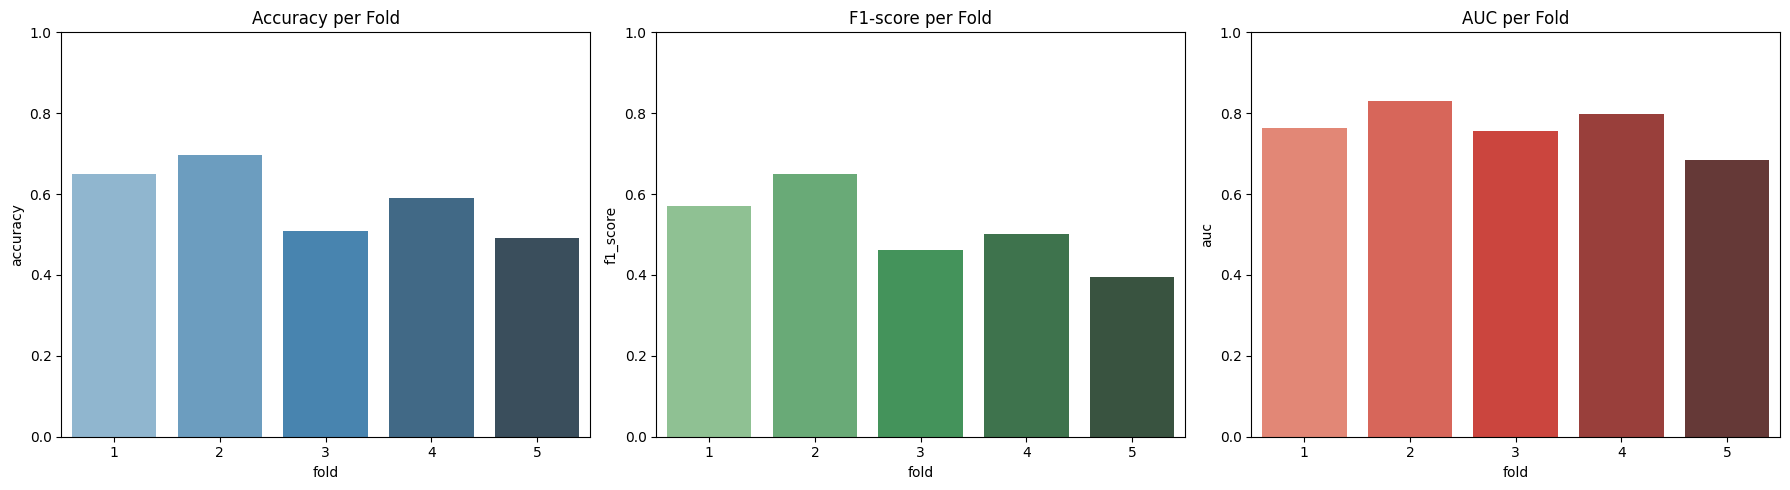

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the summary file
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/DR_Project/cv_summary.csv')
df_numeric = df[df['fold'] != 'Mean ± Std'].copy()
df_numeric['fold'] = df_numeric['fold'].astype(str)

# Convert to numeric
df_numeric['accuracy'] = pd.to_numeric(df_numeric['accuracy'], errors='coerce')
df_numeric['f1_score'] = pd.to_numeric(df_numeric['f1_score'], errors='coerce')
df_numeric['auc'] = pd.to_numeric(df_numeric['auc'], errors='coerce')

# Plot
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
sns.barplot(data=df_numeric, x='fold', y='accuracy', ax=ax[0], palette='Blues_d')
ax[0].set_title('Accuracy per Fold')
ax[0].set_ylim(0, 1)

sns.barplot(data=df_numeric, x='fold', y='f1_score', ax=ax[1], palette='Greens_d')
ax[1].set_title('F1-score per Fold')
ax[1].set_ylim(0, 1)

sns.barplot(data=df_numeric, x='fold', y='auc', ax=ax[2], palette='Reds_d')
ax[2].set_title('AUC per Fold')
ax[2].set_ylim(0, 1)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/DR_Project/fold_metrics_barplot.png', dpi=300)
plt.show()

In [ ]:
from google.colab import files

# Download bar chart image
files.download('/content/drive/MyDrive/Colab_Notebooks/DR_Project/fold_metrics_barplot.png')

# Download CV summary table
files.download('/content/drive/MyDrive/Colab_Notebooks/DR_Project/cv_summary.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import array_to_img

# Load model
model_path = '/content/drive/MyDrive/Colab_Notebooks/DR_Project/fold2_model.h5'
model = tf.keras.models.load_model(model_path)

# Load your data again
X_images = np.load('/content/drive/MyDrive/Colab_Notebooks/DR_Project/X_images.npy', mmap_mode='r')
X_meta = np.load('/content/drive/MyDrive/Colab_Notebooks/DR_Project/X_meta.npy')
y_labels = np.load('/content/drive/MyDrive/Colab_Notebooks/DR_Project/y_labels.npy')

In [ ]:
def get_gradcam_heatmap(model, image_array, class_index, meta_input=None):
    if meta_input is None:
        meta_input = np.zeros((1, 5), dtype=np.float32)

    # Convert both to tensors
    image_tensor = tf.convert_to_tensor(np.expand_dims(image_array, axis=0), dtype=tf.float32)
    meta_tensor = tf.convert_to_tensor(meta_input, dtype=tf.float32)

    # Get last conv layer from EfficientNetB0
    last_conv_layer = model.get_layer('top_conv')

    # Build model
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[last_conv_layer.output, model.output]
    )

    # Gradient calculation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model([image_tensor, meta_tensor])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-10)
    return heatmap.numpy()

In [ ]:
# Choose Fold 2 sample
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
_, val_idx = list(kf.split(X_images, y_labels))[1]
sample_index = val_idx[10]  # Change index to try different samples

image = X_images[sample_index]
meta = X_meta[sample_index].reshape(1, 5).astype(np.float32)
label = y_labels[sample_index]

heatmap = get_gradcam_heatmap(model, image, class_index=label, meta_input=meta)

# Overlay Grad-CAM
img = np.uint8(255 * image)
heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = heatmap_color * 0.4 + img

# Save image
out_path = '/content/drive/MyDrive/Colab_Notebooks/DR_Project/gradcam_fold2_sample10.png'
cv2.imwrite(out_path, superimposed_img)
print(f"✅ Saved Grad-CAM to: {out_path}")

✅ Saved Grad-CAM to: /content/drive/MyDrive/Colab_Notebooks/DR_Project/gradcam_fold2_sample10.png


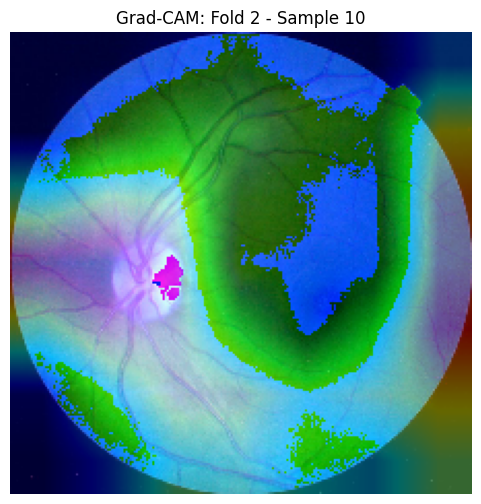

In [ ]:
# 🔁 Re-run Grad-CAM on same sample and show it in notebook
sample_index = val_idx[10]
image = X_images[sample_index]
meta = X_meta[sample_index].reshape(1, 5).astype(np.float32)
label = y_labels[sample_index]

heatmap = get_gradcam_heatmap(model, image, class_index=label, meta_input=meta)

# Overlay Grad-CAM
img = np.uint8(255 * image)
heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = heatmap_color * 0.4 + img

# Save and visualize
save_path = '/content/drive/MyDrive/Colab_Notebooks/DR_Project/gradcam_fold2_sample10.png'
cv2.imwrite(save_path, superimposed_img)

# Visualize in notebook
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(superimposed_img.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM: Fold 2 - Sample 10")
plt.axis('off')
plt.show()

In [ ]:
# Find one sample index per class (0 to 4) in the validation set
samples_per_class = {}
for idx in val_idx:
    label = y_labels[idx]
    if label not in samples_per_class:
        samples_per_class[label] = idx
    if len(samples_per_class) == 5:
        break

print(samples_per_class)  # e.g., {0: 12, 1: 34, 2: 45, 3: 78, 4: 102}

{np.int64(1): np.int64(2), np.int64(2): np.int64(8), np.int64(0): np.int64(10), np.int64(3): np.int64(13), np.int64(4): np.int64(40)}


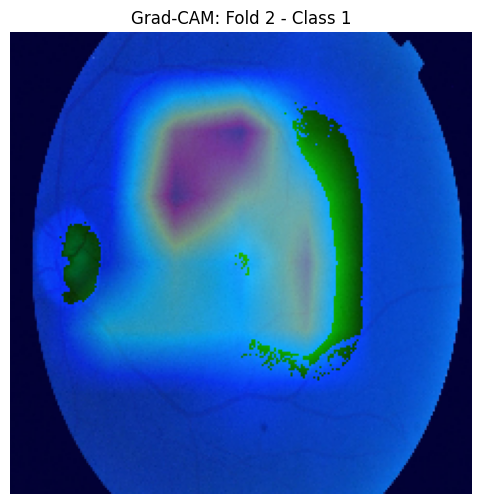

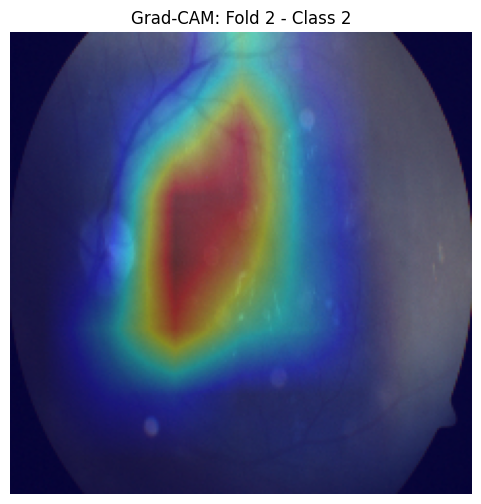

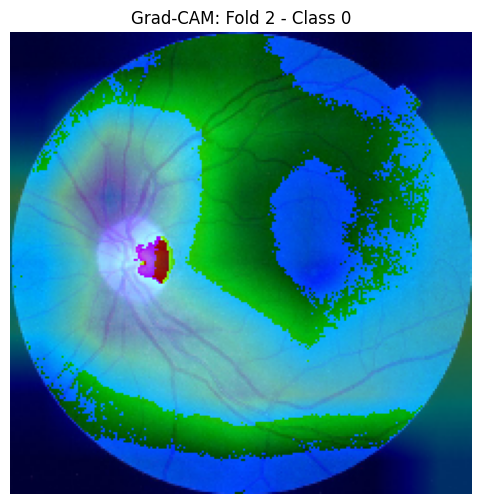

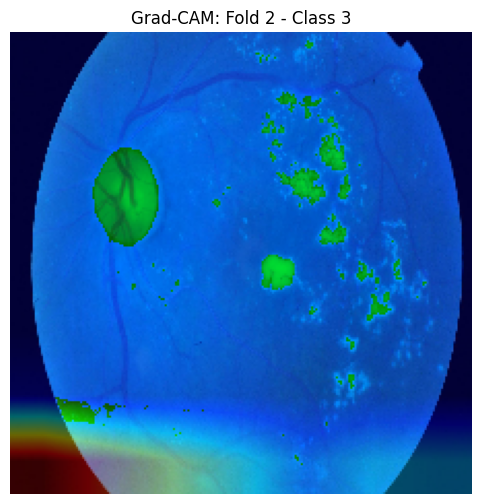

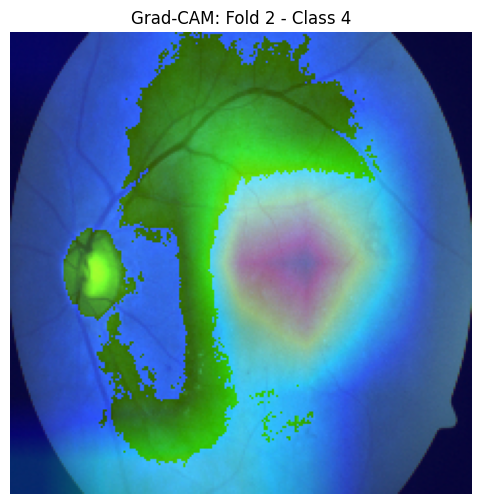

In [ ]:
for class_label, sample_index in samples_per_class.items():
    image = X_images[sample_index]
    meta = X_meta[sample_index].reshape(1, 5).astype(np.float32)
    label = y_labels[sample_index]

    # Grad-CAM heatmap
    heatmap = get_gradcam_heatmap(model, image, class_index=label, meta_input=meta)

    # Overlay Grad-CAM
    img = np.uint8(255 * image)
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * 0.4 + img

    # Save
    filename = f"/content/drive/MyDrive/Colab_Notebooks/DR_Project/gradcam_fold2_class{class_label}.png"
    cv2.imwrite(filename, superimposed_img)

    # Visualize
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(superimposed_img.astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM: Fold 2 - Class {class_label}")
    plt.axis('off')
    plt.show()

In [ ]:
metadata_input = model.input[1]  # second input = metadata
metadata_output = model.get_layer('dense_5').output  # final metadata dense layer
metadata_model = tf.keras.Model(inputs=metadata_input, outputs=metadata_output)

In [ ]:
import pandas as pd

X_meta_df = pd.DataFrame(
    X_meta,
    columns=['Age', 'Diabetes_Duration', 'HbA1c', 'Systolic_BP', 'BMI']
)

In [ ]:
feature_names = ['Age', 'Diabetes_Duration', 'HbA1c', 'Systolic_BP', 'BMI']

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/tmp/ipython-input-40-3201737794.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_meta_df.iloc[:200], feature_names=feature_names)
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


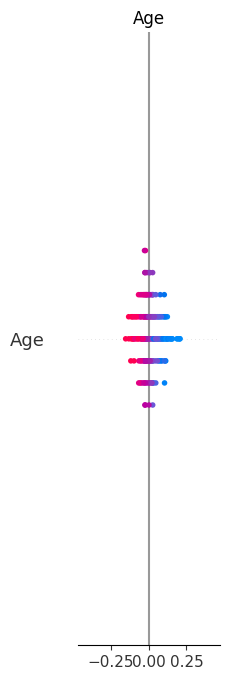

<Figure size 640x480 with 0 Axes>

In [ ]:
import shap
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Step 1: Reformat metadata as DataFrame
feature_names = ['Age', 'Diabetes_Duration', 'HbA1c', 'Systolic_BP', 'BMI']
X_meta_df = pd.DataFrame(X_meta, columns=feature_names)

# Step 2: Create a scalar-output version of the metadata model for SHAP
metadata_output = model.get_layer('dense_5').output  # your last metadata Dense layer
metadata_input = model.input[1]  # second input is metadata

metadata_model = tf.keras.Model(inputs=metadata_input, outputs=metadata_output)
metadata_model_scalar = tf.keras.Sequential([
    metadata_model,
    tf.keras.layers.Dense(1, activation='linear')
])

# Step 3: Build SHAP Kernel Explainer
background = X_meta_df.sample(100, random_state=42)
explainer = shap.KernelExplainer(metadata_model_scalar.predict, background)

# Step 4: Compute SHAP values on 200 samples
shap_values = explainer.shap_values(X_meta_df.iloc[:200], nsamples=100)

# Step 5: Plot SHAP summary
shap.summary_plot(shap_values, X_meta_df.iloc[:200], feature_names=feature_names)

# Optional: Save to file
plt.savefig("shap_metadata_summary.png", bbox_inches='tight')

In [ ]:
plt.savefig("shap_metadata_summary.png", bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [ ]:
model.summary(print_fn=lambda x: open('model_summary.txt', 'a').write(x + '\n'))

In [ ]:
# Save model architecture to text
with open('model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

In [ ]:
from google.colab import files
files.download('model_summary.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>